In [ ]:
!pip install wandb
!wandb login


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from PIL import Image, ImageOps
from skimage.metrics import structural_similarity as ssim

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os

from tensorflow.keras.datasets import fashion_mnist, cifar10

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="autoencoders_conv", entity="csc2231-yash-siphelele")

wandb: Currently logged in as: csc2231-yash-siphelele (use `wandb login --relogin` to force relogin)


In [ ]:
def fit_model_and_log_metrics(run_name, run_notes, model, epochs, batch_size):
    run = wandb.init(project="autoencoders_conv", entity="csc2231-yash-siphelele", name=run_name, notes=run_notes)
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, x_test), callbacks=[WandbCallback()]) 
    decoded_imgs = model.predict(x_test)
    ssim_scores = []
    for i in range(len(x_test)):
        ssim_value = ssim(x_test[i].reshape(28, 28), decoded_imgs[i].reshape(28, 28))
        ssim_scores.append(ssim_value)

    avg_ssim_score_x_test = np.mean(ssim_scores)
    wandb.log({"avg_ssim_score_x_test": avg_ssim_score_x_test})
    print("Avg SSIM over X_test:", avg_ssim_score_x_test)
    run.finish()

In [ ]:
class_labels = { 0: "T-shirt/top", 
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle-boot" 
            }

In [ ]:
def save_image(filename, data_array):
    im = Image.fromarray(data_array.astype('uint8'))
    im_invert = ImageOps.invert(im)
    im_invert.save(filename)

DIR_NAME = "JPEGImages"
if os.path.exists(DIR_NAME) == False:
    os.mkdir(DIR_NAME)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
# Save Images
i = 0
for li in [x_test]:
    print("[---------------------------------------------------------------]")
    for x in li:
        filename = "{0}/{1:05d}.jpg".format(DIR_NAME,i)
        print(filename)
        save_image(filename, x)
        i += 1

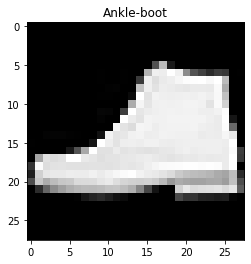

In [ ]:
# show a random image from the training set
pixels, class_label = x_train[42], class_labels[y_train[42]]
plt.title(str(class_label))
plt.imshow(pixels, cmap='gray')
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, x_test.shape) 

(60000, 28, 28) (10000, 28, 28)


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
def define_wandb_config(first_conv_filters, second_conv_filters, third_conv_filters, epochs, batch_size):
    wandb.config = {
        "first_conv_filters": first_conv_filters,
        "second_conv_filters": second_conv_filters,
        "third_conv_filters": third_conv_filters,
        "epochs": epochs,
        "batch_size": batch_size,
    }
define_wandb_config(24, 12, 8, 50, 128)

In [ ]:
# First Encoder model

def Encoder(input_img):
    x = Conv2D(24, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

In [ ]:
# First Decoder model

def Decoder(encoded):
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((4, 4))(x)
    x = Conv2D(12, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded

In [ ]:
# First Autoencoder model

input = Input(shape=(28, 28, 1))
encoder = Encoder(input)
decoder = Decoder(encoder)
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 24)        240       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 12)        2604      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 8)           872 

In [ ]:
fit_model_and_log_metrics("Model1", "With maxpooling, upsampling", autoencoder, 50, 128)

Epoch 1/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0369 - val_loss: 0.0259 - _timestamp: 1648051006.0000 - _runtime: 12.0000
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0237 - val_loss: 0.0222 - _timestamp: 1648051011.0000 - _runtime: 17.0000
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0215 - val_loss: 0.0210 - _timestamp: 1648051016.0000 - _runtime: 22.0000
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0205 - val_loss: 0.0201 - _timestamp: 1648051021.0000 - _runtime: 27.0000
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0198 - val_loss: 0.0196 - _timestamp: 1648051026.0000 - _runtime: 32.0000
Epoch 6/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0192 - val_loss: 0.0190 - _timestamp: 1648051031.0000 - _runtime: 37.0000
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0188 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.71551
best_epoch,49
best_val_loss,0.01565
epoch,49
loss,0.01571
val_loss,0.01565


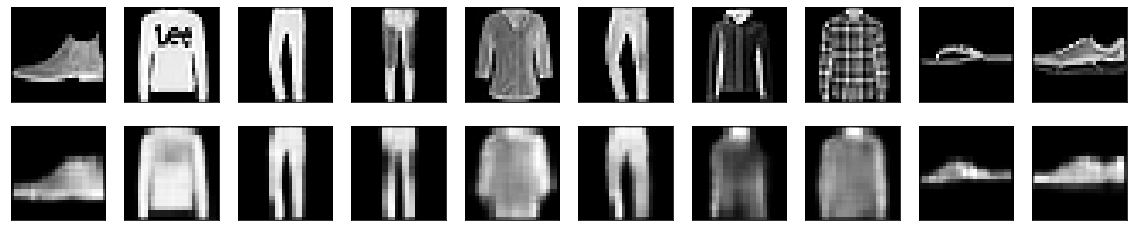

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show() 

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
ssim_scores = []
for i in range(len(x_test)):
    ssim_value = ssim(x_test[i].reshape(28, 28), decoded_imgs[i].reshape(28, 28))
    ssim_scores.append(ssim_value)

avg_ssim_score_x_test = np.mean(ssim_scores)
wandb.log({"avg_ssim_score_x_test": avg_ssim_score_x_test})
avg_ssim_score_x_test

0.7319452076628427

In [ ]:
# 2nd Encoder model

def Encoder_ConvTranspose(input_img):
    x = Conv2D(24, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

# 2nd Decoder model

def Decoder_ConvTranspose(encoded):
    x = Conv2DTranspose(8, (3, 3), strides = 2, activation='relu', padding='same')(encoded)
    x = Conv2DTranspose(12, (3, 3), strides = 2, activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


# 2nd Autoencoder model

input = Input(shape=(28, 28, 1))
encoder2 = Encoder_ConvTranspose(input)
decoder2 = Decoder_ConvTranspose(encoder2)
autoencoder2 = Model(input, decoder2)
autoencoder2.compile(optimizer = "adam", loss = "mse")
autoencoder2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 24)        240       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 12)        2604      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 8)        872 

In [ ]:
fit_model_and_log_metrics("Model 2", "With maxpooling, convtranspose", autoencoder2, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0306 - val_loss: 0.0125 - _timestamp: 1648051374.0000 - _runtime: 12.0000
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0109 - val_loss: 0.0099 - _timestamp: 1648051379.0000 - _runtime: 17.0000
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0090 - val_loss: 0.0083 - _timestamp: 1648051384.0000 - _runtime: 22.0000
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0078 - val_loss: 0.0073 - _timestamp: 1648051389.0000 - _runtime: 27.0000
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0070 - val_loss: 0.0068 - _timestamp: 1648051394.0000 - _runtime: 32.0000
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0066 - val_loss: 0.0064 - _timestamp: 1648051400.0000 - _runtime: 38.0000
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0063 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.91149
best_epoch,49
best_val_loss,0.0044
epoch,49
loss,0.0044
val_loss,0.0044


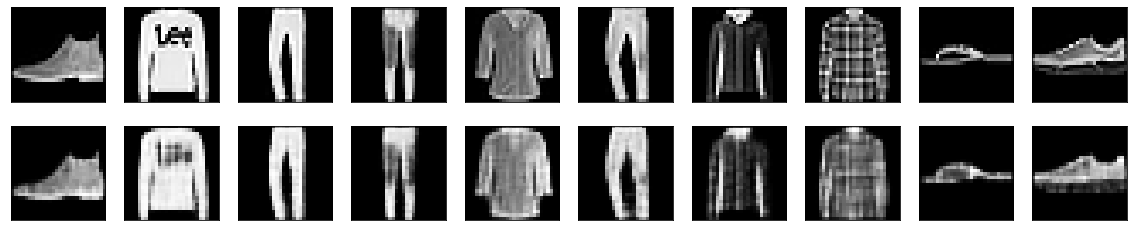

In [ ]:
decoded_imgs_2 = autoencoder2.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs_2[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

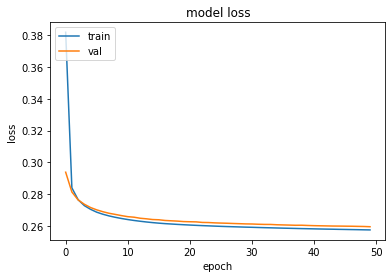

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 3rd Autoencoder model

def Encoder_ConvTranspose_2(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def Decoder_ConvTranspose_2(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1))
encoder3 = Encoder_ConvTranspose_2(input)
decoder3 = Decoder_ConvTranspose_2(encoder3)
autoencoder3 = Model(input, decoder3)
autoencoder3.compile(optimizer = "adam", loss = "mse")
autoencoder3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 16)       2320

In [ ]:
fit_model_and_log_metrics("Model 3", "With maxpooling, convtranspose", autoencoder3, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0236 - val_loss: 0.0098 - _timestamp: 1648051711.0000 - _runtime: 14.0000
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0080 - val_loss: 0.0069 - _timestamp: 1648051717.0000 - _runtime: 20.0000
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0064 - val_loss: 0.0059 - _timestamp: 1648051724.0000 - _runtime: 27.0000
Epoch 4/50
469/469 [==============================] - 8s 18ms/step - loss: 0.0056 - val_loss: 0.0054 - _timestamp: 1648051733.0000 - _runtime: 36.0000
Epoch 5/50
469/469 [==============================] - 8s 18ms/step - loss: 0.0052 - val_loss: 0.0051 - _timestamp: 1648051741.0000 - _runtime: 44.0000
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0049 - val_loss: 0.0048 - _timestamp: 1648051748.0000 - _runtime: 51.0000
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0047 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.92891
best_epoch,47
best_val_loss,0.00339
epoch,49
loss,0.00339
val_loss,0.0034


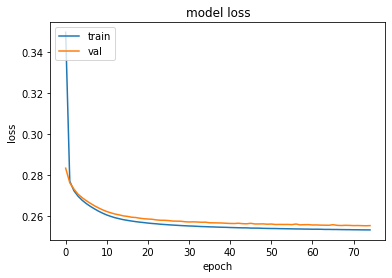

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

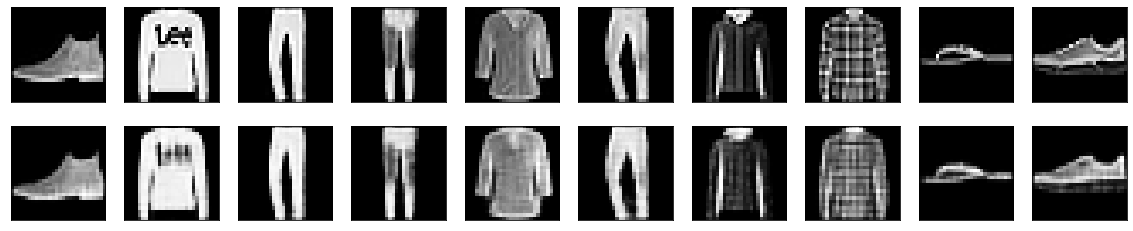

In [ ]:
decoded_imgs_3 = autoencoder3.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs_3[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 4th Autoencoder model

def Encoder_ConvTranspose_3(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def Decoder_ConvTranspose_3(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1))
encoder4 = Encoder_ConvTranspose_3(input)
decoder4 = Decoder_ConvTranspose_3(encoder4)
autoencoder4 = Model(input, decoder4)
autoencoder4.compile(optimizer = "adam", loss = "mse")
autoencoder4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 14, 14, 16)       2320

In [ ]:
fit_model_and_log_metrics("Model 4", "With maxpooling, convtranspose", autoencoder4, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0220 - val_loss: 0.0099 - _timestamp: 1648052112.0000 - _runtime: 15.0000
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0081 - val_loss: 0.0068 - _timestamp: 1648052118.0000 - _runtime: 21.0000
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0062 - val_loss: 0.0058 - _timestamp: 1648052125.0000 - _runtime: 28.0000
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0054 - val_loss: 0.0052 - _timestamp: 1648052132.0000 - _runtime: 35.0000
Epoch 5/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0050 - val_loss: 0.0048 - _timestamp: 1648052139.0000 - _runtime: 42.0000
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0047 - val_loss: 0.0046 - _timestamp: 1648052146.0000 - _runtime: 49.0000
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0044 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.93595
best_epoch,48
best_val_loss,0.00298
epoch,49
loss,0.00296
val_loss,0.00299


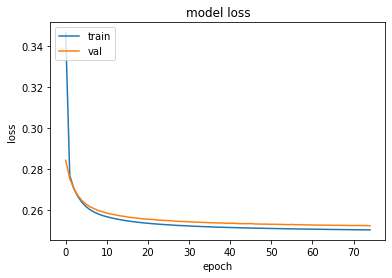

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

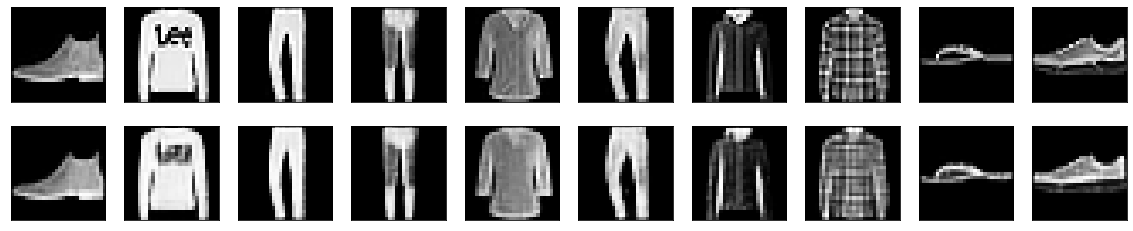

In [ ]:
decoded_imgs_4 = autoencoder4.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs_4[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 5th Autoencoder model

def Encoder_ConvTranspose_4(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(16, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder_ConvTranspose_4(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1)) 
encoder5 = Encoder_ConvTranspose_4(input)
decoder5 = Decoder_ConvTranspose_4(encoder5)
autoencoder5 = Model(input, decoder5)
autoencoder5.compile(optimizer = "adam", loss = "mse")
autoencoder5.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 16)          2320      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 16)       2320      
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 28, 28, 32)       4640      
 Transpose)                                                

In [ ]:
fit_model_and_log_metrics("Model 5", "With maxpooling, convtranspose", autoencoder5, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0221 - val_loss: 0.0076 - _timestamp: 1648052566.0000 - _runtime: 13.0000
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0056 - val_loss: 0.0043 - _timestamp: 1648052572.0000 - _runtime: 19.0000
Epoch 3/50
469/469 [==============================] - 6s 14ms/step - loss: 0.0037 - val_loss: 0.0033 - _timestamp: 1648052578.0000 - _runtime: 25.0000
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0030 - val_loss: 0.0027 - _timestamp: 1648052584.0000 - _runtime: 31.0000
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0025 - val_loss: 0.0024 - _timestamp: 1648052591.0000 - _runtime: 38.0000
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0022 - val_loss: 0.0021 - _timestamp: 1648052597.0000 - _runtime: 44.0000
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0020 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.99153
best_epoch,48
best_val_loss,0.00037
epoch,49
loss,0.00039
val_loss,0.00038


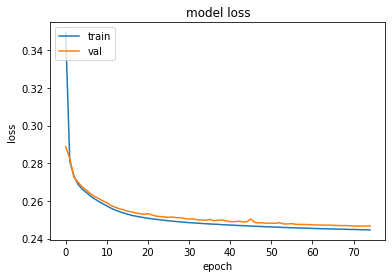

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

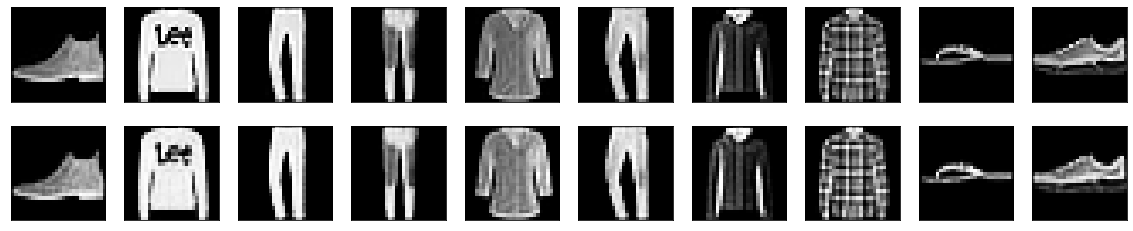

In [ ]:
decoded_imgs_5 = autoencoder5.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs_5[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs_5.shape

(10000, 28, 28, 1)

In [ ]:
def save_image(filename, data_array):
    np_img = np.squeeze(data_array, axis=2)  # axis=2 is channel dimension 
    im = Image.fromarray((np_img * 255).astype('uint8'))
    # im = Image.fromarray(data_array.astype('uint8'))
    im_invert = ImageOps.invert(im)
    im_invert.save(filename)

In [ ]:
DIR_NAME_DEC = 'X_TEST_DECODED'

if os.path.exists(DIR_NAME_DEC) == False:
    os.mkdir(DIR_NAME_DEC)

i = 0
for img in decoded_imgs_5:
    filename = "{0}/{1:05d}.jpg".format(DIR_NAME_DEC,i)
    print(filename)
    save_image(filename, img)
    i += 1

In [ ]:
!rm -r X_TEST_DECODED

In [ ]:
!zip -r X_TEST_DECODED.zip X_TEST_DECODED/ 

In [ ]:
!zip -r JPEGImages.zip JPEGImages/ 

In [ ]:
# 6th Autoencoder model

def Encoder_ConvTranspose_5(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder_ConvTranspose_5(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1)) 
encoder6 = Encoder_ConvTranspose_5(input)
decoder6 = Decoder_ConvTranspose_5(encoder6)
autoencoder6 = Model(input, decoder6)
autoencoder6.compile(optimizer = "adam", loss = "mse")
autoencoder6.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 conv2d_42 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 14, 14, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 28, 28, 32)       4640      
 Transpose)                                               

In [ ]:
fit_model_and_log_metrics("Model 6", "With maxpooling, convtranspose", autoencoder6, epochs=50, batch_size=128) 

Epoch 1/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0233 - val_loss: 0.0093 - _timestamp: 1648052903.0000 - _runtime: 12.0000
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0074 - val_loss: 0.0061 - _timestamp: 1648052909.0000 - _runtime: 18.0000
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0051 - val_loss: 0.0045 - _timestamp: 1648052915.0000 - _runtime: 24.0000
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0041 - val_loss: 0.0038 - _timestamp: 1648052921.0000 - _runtime: 30.0000
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0035 - val_loss: 0.0033 - _timestamp: 1648052928.0000 - _runtime: 37.0000
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0031 - val_loss: 0.0029 - _timestamp: 1648052933.0000 - _runtime: 42.0000
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0028 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.96906
best_epoch,49
best_val_loss,0.00149
epoch,49
loss,0.00151
val_loss,0.00149


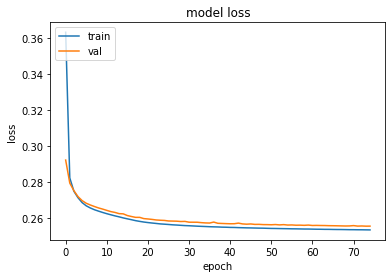

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

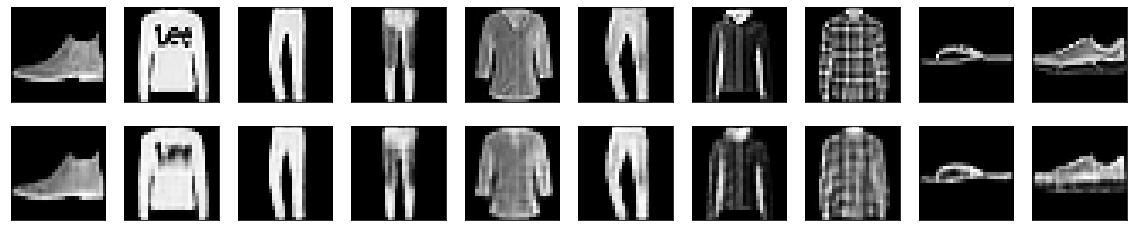

In [ ]:
decoded_imgs_6 = autoencoder6.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs_6[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Model 7

def Encoder_ConvTranspose_6(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder_ConvTranspose_6(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1)) 
encoder7 = Encoder_ConvTranspose_6(input)
decoder7 = Decoder_ConvTranspose_6(encoder7)
autoencoder7 = Model(input, decoder7)
autoencoder7.compile(optimizer = "adam", loss = "mse")
autoencoder7.summary()

fit_model_and_log_metrics("Model 6.1", "With maxpooling, convtranspose", autoencoder7, epochs=75, batch_size=128) 

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_45 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 conv2d_46 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 14, 14, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 28, 28, 32)       4640      
 Transpose)                                               

Epoch 1/75
469/469 [==============================] - 7s 14ms/step - loss: 0.0253 - val_loss: 0.0103 - _timestamp: 1648054018.0000 - _runtime: 13.0000
Epoch 2/75
469/469 [==============================] - 6s 14ms/step - loss: 0.0072 - val_loss: 0.0054 - _timestamp: 1648054024.0000 - _runtime: 19.0000
Epoch 3/75
469/469 [==============================] - 7s 14ms/step - loss: 0.0046 - val_loss: 0.0041 - _timestamp: 1648054031.0000 - _runtime: 26.0000
Epoch 4/75
469/469 [==============================] - 7s 15ms/step - loss: 0.0038 - val_loss: 0.0035 - _timestamp: 1648054038.0000 - _runtime: 33.0000
Epoch 5/75
469/469 [==============================] - 7s 15ms/step - loss: 0.0033 - val_loss: 0.0032 - _timestamp: 1648054045.0000 - _runtime: 40.0000
Epoch 6/75
469/469 [==============================] - 7s 15ms/step - loss: 0.0029 - val_loss: 0.0028 - _timestamp: 1648054052.0000 - _runtime: 47.0000
Epoch 7/75
469/469 [==============================] - 8s 17ms/step - loss: 0.0027 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.97141
best_epoch,74
best_val_loss,0.00136
epoch,74
loss,0.00137
val_loss,0.00136


In [ ]:
# Model 8

def Encoder_ConvTranspose_7(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder_ConvTranspose_7(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1)) 
encoder8 = Encoder_ConvTranspose_7(input)
decoder8 = Decoder_ConvTranspose_7(encoder8)
autoencoder8 = Model(input, decoder8)
autoencoder8.compile(optimizer = "adam", loss = "mse")
autoencoder8.summary()

fit_model_and_log_metrics("Model 6.2", "With maxpooling, convtranspose", autoencoder8, epochs=50, batch_size=256)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_49 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 conv2d_50 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 28, 28, 32)       4640      
 Transpose)                                               

Epoch 1/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0374 - val_loss: 0.0146 - _timestamp: 1648054540.0000 - _runtime: 13.0000
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 0.0115 - val_loss: 0.0091 - _timestamp: 1648054545.0000 - _runtime: 18.0000
Epoch 3/50
235/235 [==============================] - 5s 22ms/step - loss: 0.0078 - val_loss: 0.0068 - _timestamp: 1648054550.0000 - _runtime: 23.0000
Epoch 4/50
235/235 [==============================] - 5s 21ms/step - loss: 0.0061 - val_loss: 0.0057 - _timestamp: 1648054555.0000 - _runtime: 28.0000
Epoch 5/50
235/235 [==============================] - 5s 22ms/step - loss: 0.0052 - val_loss: 0.0049 - _timestamp: 1648054561.0000 - _runtime: 34.0000
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.0046 - val_loss: 0.0044 - _timestamp: 1648054565.0000 - _runtime: 38.0000
Epoch 7/50
235/235 [==============================] - 5s 21ms/step - loss: 0.0042 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.96396
best_epoch,47
best_val_loss,0.00174
epoch,49
loss,0.00174
val_loss,0.00175


In [ ]:
# Model 9

def Encoder_ConvTranspose_7(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder_ConvTranspose_7(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), padding='same')(x)
    return decoded


input = Input(shape=(28, 28, 1)) 
encoder8 = Encoder_ConvTranspose_7(input)
decoder8 = Decoder_ConvTranspose_7(encoder8)
autoencoder8 = Model(input, decoder8)
autoencoder8.compile(optimizer = "adam", loss = "mse")
autoencoder8.summary()

fit_model_and_log_metrics("Model 6.3", "With maxpooling, convtranspose", autoencoder8, epochs=75, batch_size=256)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_53 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 conv2d_54 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 14, 14, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 28, 28, 32)       4640      
 Transpose)                                               

Epoch 1/75
235/235 [==============================] - 6s 22ms/step - loss: 0.0335 - val_loss: 0.0143 - _timestamp: 1648055857.0000 - _runtime: 11.0000
Epoch 2/75
235/235 [==============================] - 5s 22ms/step - loss: 0.0112 - val_loss: 0.0088 - _timestamp: 1648055863.0000 - _runtime: 17.0000
Epoch 3/75
235/235 [==============================] - 5s 21ms/step - loss: 0.0075 - val_loss: 0.0064 - _timestamp: 1648055868.0000 - _runtime: 22.0000
Epoch 4/75
235/235 [==============================] - 5s 21ms/step - loss: 0.0057 - val_loss: 0.0052 - _timestamp: 1648055873.0000 - _runtime: 27.0000
Epoch 5/75
235/235 [==============================] - 5s 22ms/step - loss: 0.0048 - val_loss: 0.0045 - _timestamp: 1648055878.0000 - _runtime: 32.0000
Epoch 6/75
235/235 [==============================] - 5s 22ms/step - loss: 0.0042 - val_loss: 0.0040 - _timestamp: 1648055883.0000 - _runtime: 37.0000
Epoch 7/75
235/235 [==============================] - 5s 22ms/step - loss: 0.0039 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.96767
best_epoch,74
best_val_loss,0.00163
epoch,74
loss,0.00163
val_loss,0.00163
